# Reference
[uproot documentation](https://uproot.readthedocs.io/en/latest/)

In [1]:
def make_sequential(obj):
    seq_events = np.zeros_like(obj.event)
    seq_events[0] = obj.event[0]
    seq_event = 0
    seq_files = np.zeros_like(obj.event)
    seq_files[0] = obj.event[0]
    seq_file = 0
    for i in range(1, len(obj.event)):
        if obj.event[i] != obj.event[i - 1]:
            seq_event += 1
        if obj.event[i] < obj.event[i - 1]:
            seq_file += 1
        seq_events[i] = seq_event
        seq_files[i] = seq_file
    obj.event = seq_events
    obj.file = seq_files

In [2]:
import uproot, numpy as np

def make_semilog_binning(low, high):
    space = []
    for i in range(int(np.floor(np.log10(low))), int(np.ceil(np.log10(high)))):
        this_space = np.linspace(10**i, 10**(i + 1), 10)
        space.append(this_space[1:] if space else this_space)
    space = np.concatenate(space)
    return space

class MCValidation:
    def __init__(self, filename, treename):
        file = uproot.open(filename)
        tree = file[treename]
        self.event = tree['event'].array(library="np") #linear list of events
        self.orig_event = tree["event"].array(library="np") #actual event number
        self.file = np.zeros_like(self.event)
        self.mc_id = tree["mcId"].array(library="np") #number of mc particles in event
        self.mc_pdg = tree["mcPDG"].array(library="np") #pdg code of particles in each event
        self.mc_tier = tree["mcTier"].array(library="np") #Which tier each event is folded back to
        self.mc_nhits = tree["mcNHits"].array(library="np") #number of mc particles hits in event
        self.mc_momentum = tree["mcMomentum"].array(library="np") #momentum of mc particles in event
        is_nu_int = tree["isNuInteration"].array(library="np") #not functioning
        is_cr_int = tree["isCosmicRay"].array(library="np") #not functioning
        is_tb_int = tree["isTestBeam"].array(library="np") #not functioning
        self.environment = np.full(is_nu_int.shape, "??") #not functioning
        self.environment[np.where(is_nu_int)] = "nu" #not functioning
        self.environment[np.where(is_cr_int)] = "tb" #not functioning
        self.environment[np.where(is_tb_int)] = "cr" #not functioning
        self.is_leading_lepton = tree["isLeadingLepton"].array(library="np")
        self.is_michel = tree["isMichel"].array(library="np")
        self.n_matches = tree["nMatches"].array(library="np")
        self.reco_id_list = tree["recoIdVector"].array(library="np")
        self.reco_nhits_list = tree["nRecoHitsVector"].array(library="np")
        self.shared_nhits_list = tree["nSharedHitsVector"].array(library="np")
        self.purity_adc_list = tree["purityAdcVector"].array(library="np")
        self.purity_list = tree["purityVector"].array(library="np")
        self.purity_list_u = tree["purityVectorU"].array(library="np")
        self.purity_list_v = tree["purityVectorV"].array(library="np")
        self.purity_list_w = tree["purityVectorW"].array(library="np")
        self.purity_adc_list_u = tree["purityAdcVectorU"].array(library="np")
        self.purity_adc_list_v = tree["purityAdcVectorV"].array(library="np")
        self.purity_adc_list_w = tree["purityAdcVectorW"].array(library="np")
        self.completeness_list = tree["completenessVector"].array(library="np")
        self.completeness_adc_list = tree["completenessAdcVector"].array(library="np")
        self.completeness_list_u = tree["completenessVectorU"].array(library="np")
        self.completeness_list_v = tree["completenessVectorV"].array(library="np")
        self.completeness_list_w = tree["completenessVectorW"].array(library="np")
        self.completeness_adc_list_u = tree["completenessAdcVectorU"].array(library="np")
        self.completeness_adc_list_v = tree["completenessAdcVectorV"].array(library="np")
        self.completeness_adc_list_w = tree["completenessAdcVectorW"].array(library="np")
        self.is_cc = tree["isCC"].array(library="np")
        self.is_qe = tree["isQE"].array(library="np")
        self.is_res = tree["isResonant"].array(library="np")
        self.is_dis = tree["isDIS"].array(library="np")
        self.is_coh = tree["isCoherent"].array(library="np")
        self.is_numu = tree["isNuMu"].array(library="np")
        self.is_nue = tree["isNuE"].array(library="np")
        self.n_pizero = tree["nPiZero"].array(library="np")
        self.n_pic = tree["nPiMinus"].array(library="np") + tree["nPiPlus"].array(library="np")
        self.n_photons = tree["nPhotons"].array(library="np")
        self.n_protons = tree["nProtons"].array(library="np")
        self.pc_metric = self.purity_adc_list * self.completeness_adc_list
        file.close()
        make_sequential(self)

import matplotlib.pyplot as plt

class PlotFormat:
    def __init__(self, title="", xlabel="x", ylabel="y", xlim=None, ylim=None, titlesize=24, labelsize=18, is_logx=False,
                is_semilogx=False, is_logy=False, is_semilogy=False, filename="placeholder"):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xlim = xlim
        self.ylim = ylim
        self.titlesize = titlesize
        self.labelsize = labelsize
        self.is_logx = is_logx
        self.is_logy = is_logy
        self.is_semilogx = is_semilogx
        self.is_semilogy = is_semilogy
        self.filename = filename

class Metric:
    def __init__(self, bin_var, bins):
        self.low = bins[0]
        self.high = bins[-1]
        self.bins = bins
        self.n_bins = len(bins) - 1
        self.x = bins
        self.y = np.zeros_like(self.x)
        self.y_err_low = np.zeros_like(self.y)
        self.y_err_high = np.zeros_like(self.y)
        self.y_errs = np.array(list(zip(self.y_err_low, self.y_err_high))).T
    
    def suppress_empty(self, empty_val=-1):
        selection_idx = np.where(self.y != empty_val)
        self.y = self.y[selection_idx]
        self.x = self.x[selection_idx]
        self.y_err_low = self.y_err_low[selection_idx]
        self.y_err_high = self.y_err_high[selection_idx]
        self.y_errs = np.array(list(zip(self.y_err_high, self.y_err_low))).T

In [3]:
def get_efficiency(efficiency, bin_var, bins):
    metric = Metric(bin_var, bins)
    
    for i in range(metric.n_bins):
        if i > (metric.n_bins - 1):
            idx = np.where((bin_var >= metric.bins[i]) & (bin_var < (metric.bins[i + 1])))
        else:
            idx = np.where((bin_var >= metric.bins[i]) & (bin_var <= (metric.bins[i + 1])))
        if len(idx[0]) > 0:
            selection = efficiency[idx]
            metric.y[i] = np.mean(selection)
            metric.y_err_low[i] = metric.y_err_high[i] = np.sqrt(metric.y[i] * (1 - metric.y[i]) / len(selection))
        else:
            metric.y[i] = -1

    metric.suppress_empty()
    
    return metric

def get_purity_or_completeness(p_or_c, bin_var, bins):
    metric = Metric(bin_var, bins)
    
    for i in range(metric.n_bins):
        if i > (metric.n_bins - 1):
            idx = np.where((bin_var >= metric.bins[i]) & (bin_var < (metric.bins[i + 1])))
        else:
            idx = np.where((bin_var >= metric.bins[i]) & (bin_var <= (metric.bins[i + 1])))
        if len(idx[0]) > 0:
            selection = p_or_c[idx]
            metric.y[i] = np.median(selection)
            metric.y_err_low[i], metric.y_err_high[i] = np.quantile(selection, [0.5 - 0.34135, 0.5 + 0.34135])
        else:
            metric.y[i] = -1

    metric.suppress_empty()
    
    return metric

def get_purity(p, bin_var, bins):
    return get_purity_or_completeness(p, bin_var, bins)

def get_completeness(c, bin_var, bins):
    return get_purity_or_completeness(c, bin_var, bins)

def get_purity_or_completeness_fraction(p_or_c, metric, plot_format):
    bins = np.linspace(0, 1, 21)
    weights = np.ones_like(p_or_c) / len(p_or_c)
    h, _ = np.histogram(p_or_c, bins=bins)
    idx = np.where(h > 0)
    e = np.array([ np.sqrt(val) / val if val > 0 else 0 for val in h ])
    y, _ = np.histogram(p_or_c, bins=bins, weights=weights)
    x = (bins[1:] + bins[:-1]) / 2
    
    y = y[idx]
    x = x[idx]
    e = e[idx] * y
    
    plt.rcParams["figure.figsize"] = (20, 15)
    fig, ax = plt.subplots()
    
    ax.set_title(plot_format.title, fontsize=plot_format.titlesize)
    ax.tick_params(axis='x', labelsize=plot_format.labelsize)
    ax.tick_params(axis='y', labelsize=plot_format.labelsize)
    ax.set_xlabel(plot_format.xlabel, fontsize=plot_format.titlesize)
    ax.set_ylabel(plot_format.ylabel, fontsize=plot_format.titlesize)
    if not plot_format.xlim is None:
        plt.xlim(plot_format.xlim[0], plot_format.xlim[1])
    if not plot_format.ylim is None:
        plt.ylim(plot_format.ylim[0], plot_format.ylim[1])
        
    plt.errorbar(x, y, xerr=0.05 / 2, yerr = e, fmt='o', markersize = '4', lw=2, elinewidth=2)
    
    plt.tight_layout()
    save_plot(fig, plot_format.filename)
    
    plt.show()

def get_purity_fraction(purity, plot_format):
    get_purity_or_completeness_fraction(purity, "purity", plot_format)
    
def get_completeness_fraction(completeness, plot_format):
    get_purity_or_completeness_fraction(completeness, "completeness", plot_format)
    
def plot_metric(x, y, err, plot_format, metric="completeness"):
    plt.rcParams["figure.figsize"] = (20, 15)
    fig, ax = plt.subplots()
    
    ax.set_title(plot_format.title, fontsize=plot_format.titlesize)
    ax.tick_params(axis='x', labelsize=plot_format.labelsize)
    ax.tick_params(axis='y', labelsize=plot_format.labelsize)
    ax.set_xlabel(plot_format.xlabel, fontsize=plot_format.titlesize)
    ax.set_ylabel(plot_format.ylabel, fontsize=plot_format.titlesize)
    if plot_format.is_logx:
        plt.logx()
    elif plot_format.is_semilogx:
        plt.semilogx()
    if plot_format.is_logy:
        plt.logy()
    elif plot_format.is_semilogy:
        plt.semilogy()
    if not plot_format.xlim is None:
        plt.xlim(plot_format.xlim[0], plot_format.xlim[1])
    if not plot_format.ylim is None:
        plt.ylim(plot_format.ylim[0], plot_format.ylim[1])
    
    if metric.lower() in ['purity', 'completeness']:
        plt.plot(x, y, label = "median", lw=2)
        color = plt.gca().lines[-1].get_color()
        plt.plot(x, err[0], color=color, lw=2, linestyle='dashed', label = "84.1%")
        plt.plot(x, err[1], color=color, lw=2, linestyle='dashed', label = "15.9%")
        plt.legend(fontsize=plot_format.titlesize)
    elif metric.lower() == 'efficiency':
        bin_width = (x[1] - x[0])
        plt.errorbar(x, y, xerr=bin_width / 2, yerr = err, fmt='o', lw=2, markersize = '4', elinewidth=2)
    
    plt.tight_layout()
    save_plot(fig, plot_format.filename)
    
    plt.show()

In [4]:
import os

def save_plot(fig, filename, subdir=None):
    if subdir is None:
        subdir = ""
    elif subdir.startswith("/"):
        subdir = subdir[1:]
        
    if not os.path.exists('images'):
        os.mkdir('images')
    for img_type in [ "png", "svg", "eps" ]:
        if not os.path.exists(f'images/{img_type}'):
            os.mkdir(f'images/{img_type}')
        if not os.path.exists(f'images/{img_type}/{subdir}'):
            os.mkdir(f'images/{img_type}/{subdir}')
        fig.savefig(f'images/{img_type}/{subdir}/{filename}.{img_type}', dpi=200, facecolor='w')

In [11]:
def get_metric_arrays(validation, idx):
    completeness = validation.completeness_list[idx]
    purity = validation.purity_list[idx]

    index_array = [ np.argmax(val) if len(val) > 0 else -1 for val in completeness ] 
    completeness_array = np.array([ np.max(val) if len(val) > 0 else 0 for val in completeness ])
    purity_array = np.array([ purity[i][index_array[i]] if index_array[i] != -1 else 0 for i in range(len(purity)) ])
    
    efficiency_array = np.array((completeness_array >= 0.5) & (purity_array >= 0.5))

    return purity_array, completeness_array, efficiency_array

def make_completeness_plots(pdg, completeness_array, mc_nhits, mc_mom, filename):
    bins = make_semilog_binning(np.min(mc_nhits), np.max(mc_nhits))
    plot_format = PlotFormat(title=pdg_to_id[pdg], xlabel="num true hits", ylabel="completeness",
                             xlim=(1, np.max(mc_nhits)), ylim=(0, 1.01), is_semilogx=True, filename=f"{filename}_nhits")
    metric = get_completeness(completeness_array, mc_nhits, bins)
    plot_metric(metric.x, metric.y, metric.y_errs, plot_format, "completeness")


    plot_format = PlotFormat(title=pdg_to_id[pdg], xlabel="completeness", ylabel="fraction",
                             xlim=(0, 1), ylim=(0, 1.01), filename=f"{filename}_frac")
    get_completeness_fraction(completeness_array, plot_format)

def make_purity_plots(pdg, purity_array, mc_nhits, mc_mom, filename):
    bins = make_semilog_binning(np.min(mc_nhits), np.max(mc_nhits))
    plot_format = PlotFormat(title=pdg_to_id[pdg], xlabel="num true hits", ylabel="purity",
                             xlim=(1, np.max(mc_nhits)), ylim=(0, 1.01), is_semilogx=True, filename=f"{filename}_nhits")
    metric = get_purity(purity_array, mc_nhits, bins)
    plot_metric(metric.x, metric.y, metric.y_errs, plot_format, "purity")

    plot_format = PlotFormat(title=pdg_to_id[pdg], xlabel="purity", ylabel="fraction", xlim=(0, 1), ylim=(0, 1.01),
                             filename=f"{filename}_frac")
    get_purity_fraction(purity_array, plot_format)

def make_efficiency_plots(pdg, efficiency_array, mc_nhits, mc_mom, filename):
    bins = make_semilog_binning(np.min(mc_nhits), np.max(mc_nhits))
    plot_format = PlotFormat(title=pdg_to_id[pdg], xlabel="num true hits", ylabel="efficiency",
                             xlim=(1, np.max(mc_nhits)), ylim=(0, 1.01), is_semilogx=True, filename=f"{filename}_nhits")
    metric = get_efficiency(efficiency_array, mc_nhits, bins)
    plot_metric(metric.x, metric.y, metric.y_errs, plot_format, "efficiency")



In [6]:
pdg_to_id = {11: r"$e$", 13: r"$\mu$", 22: r"$\gamma$", 211: r"$\pi$", 2212: r"$p$"}

# MC validation

In [15]:
validation = MCValidation("../../run/hierarchy_validation_simple_all_energies.root", "mc")

## Inclusive particle metrics

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


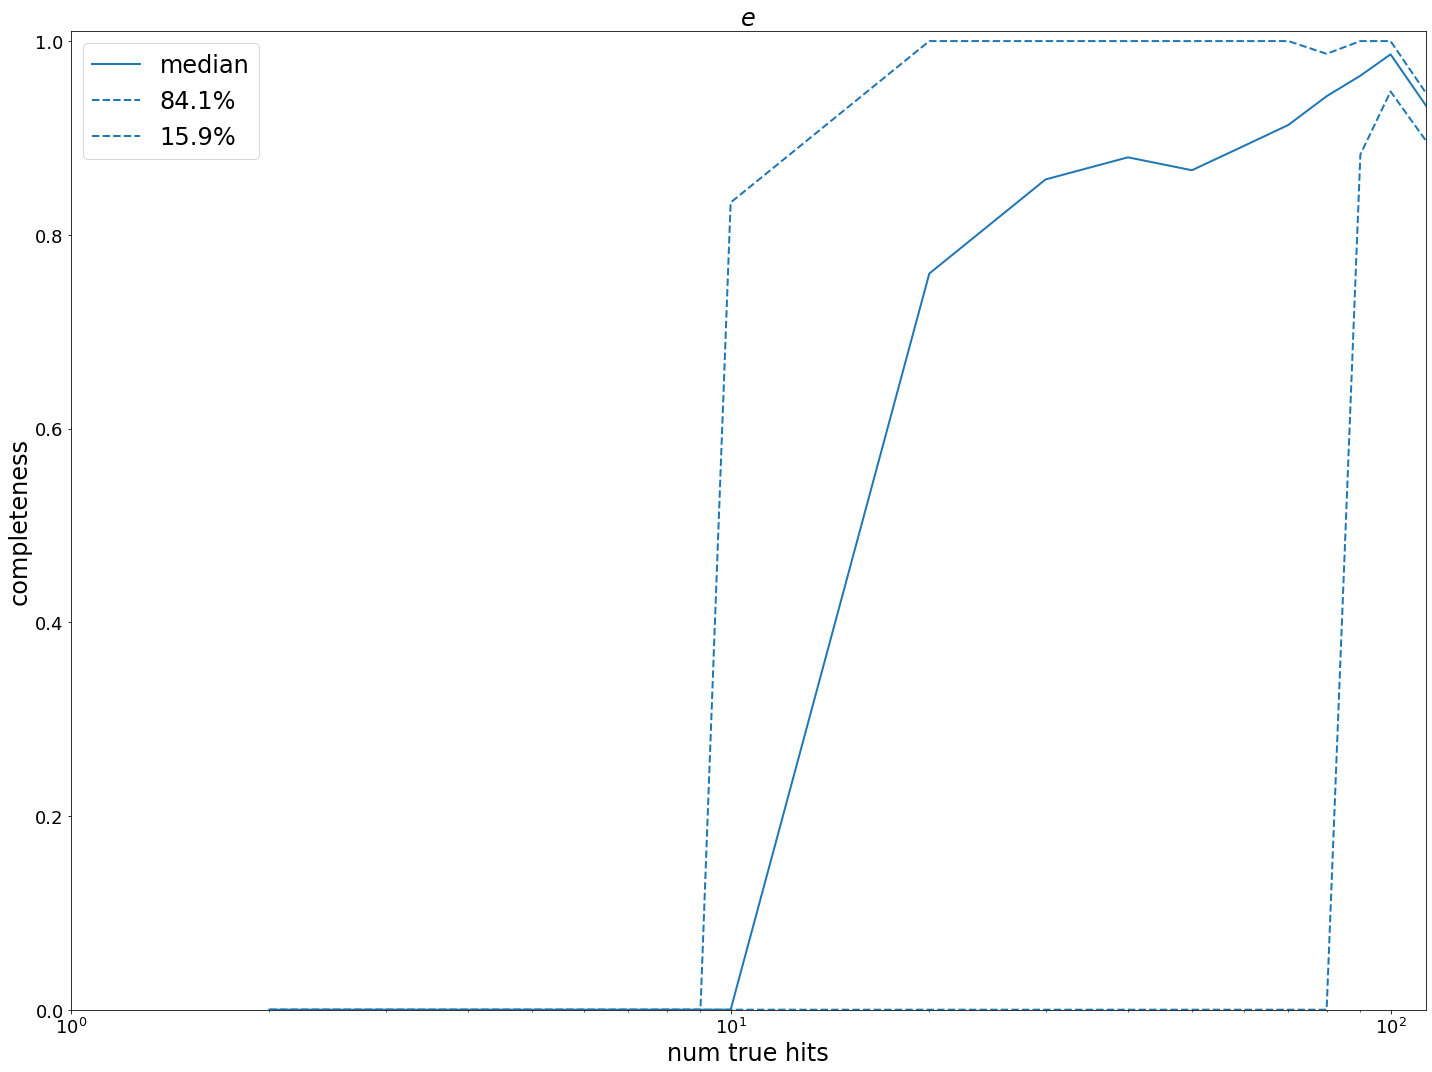

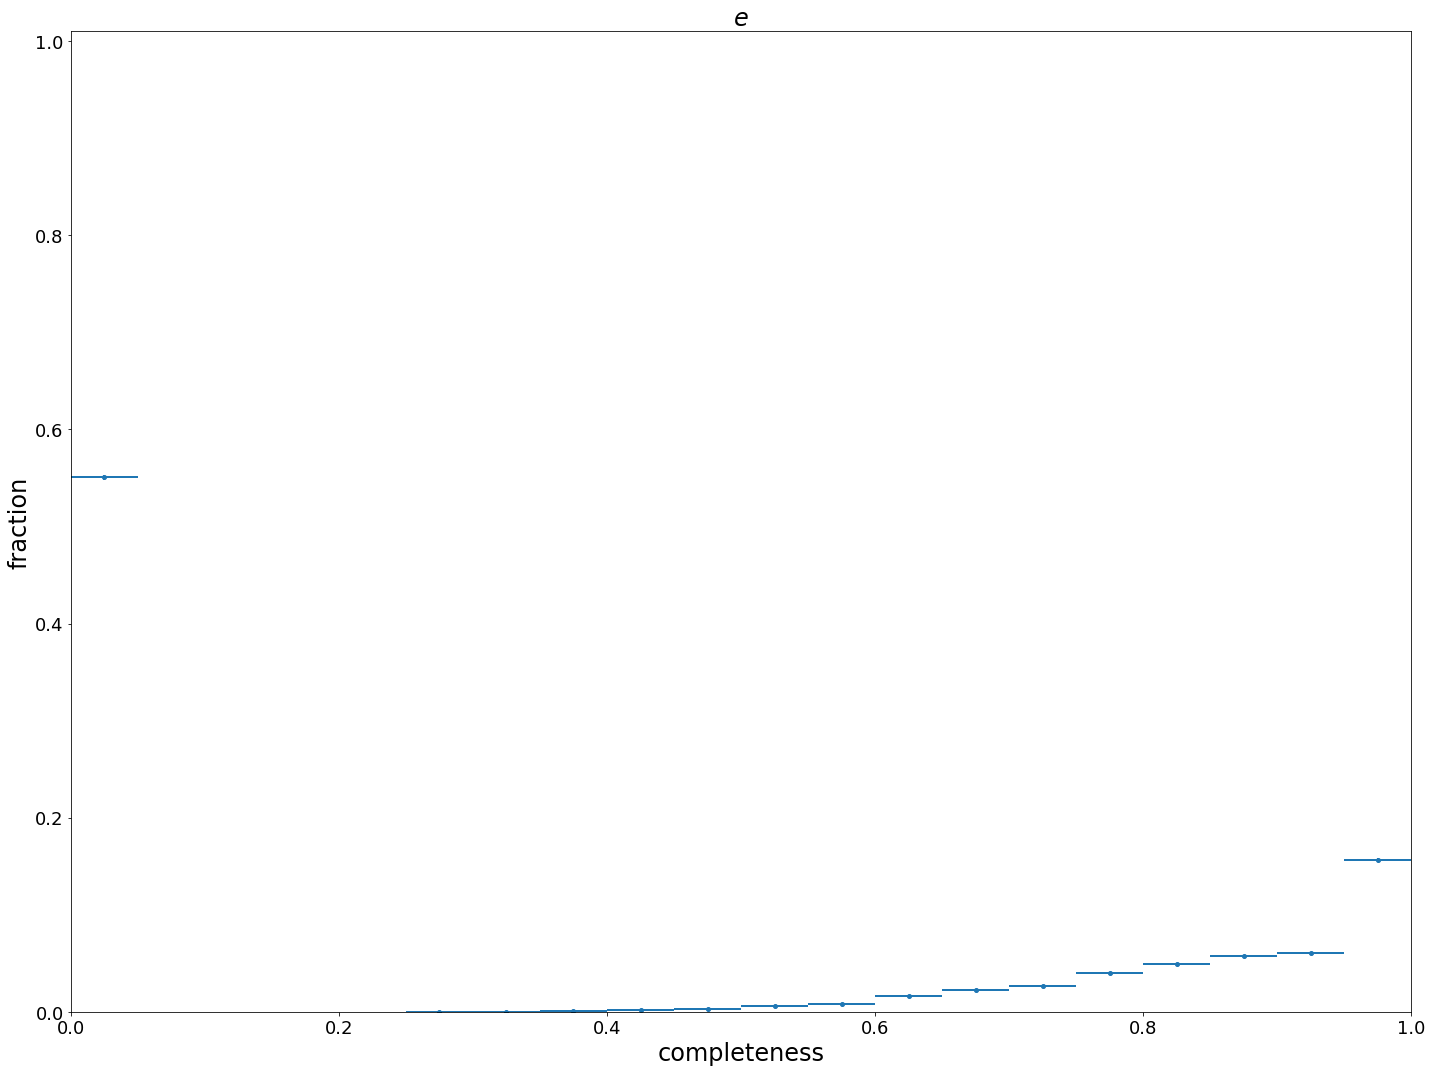

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


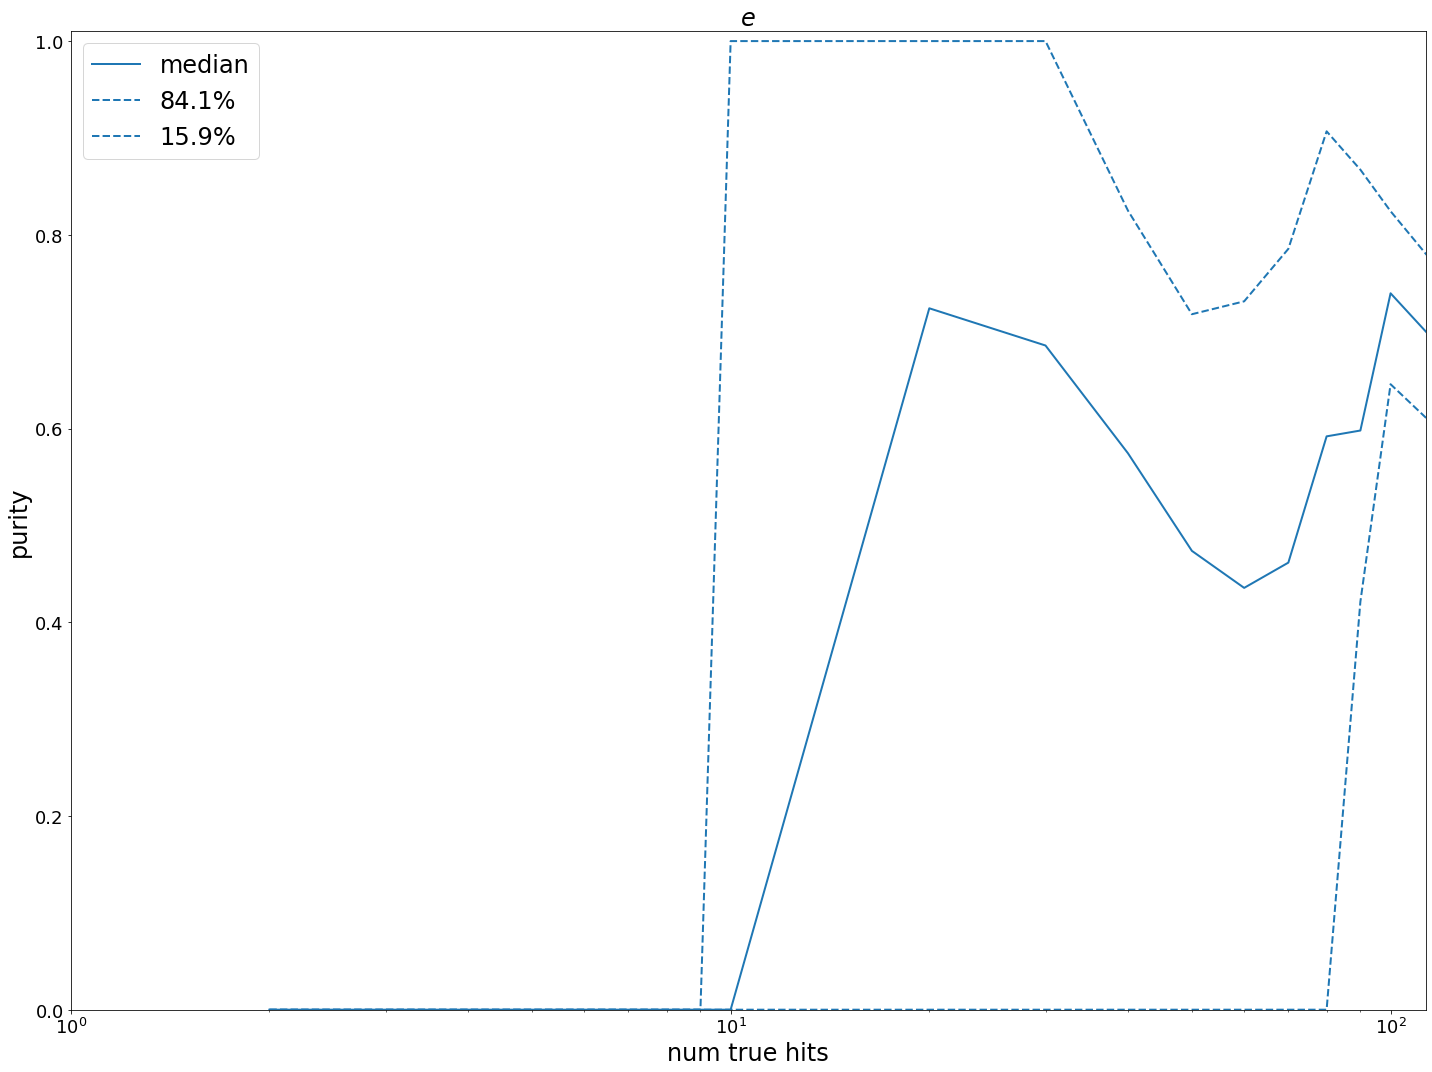

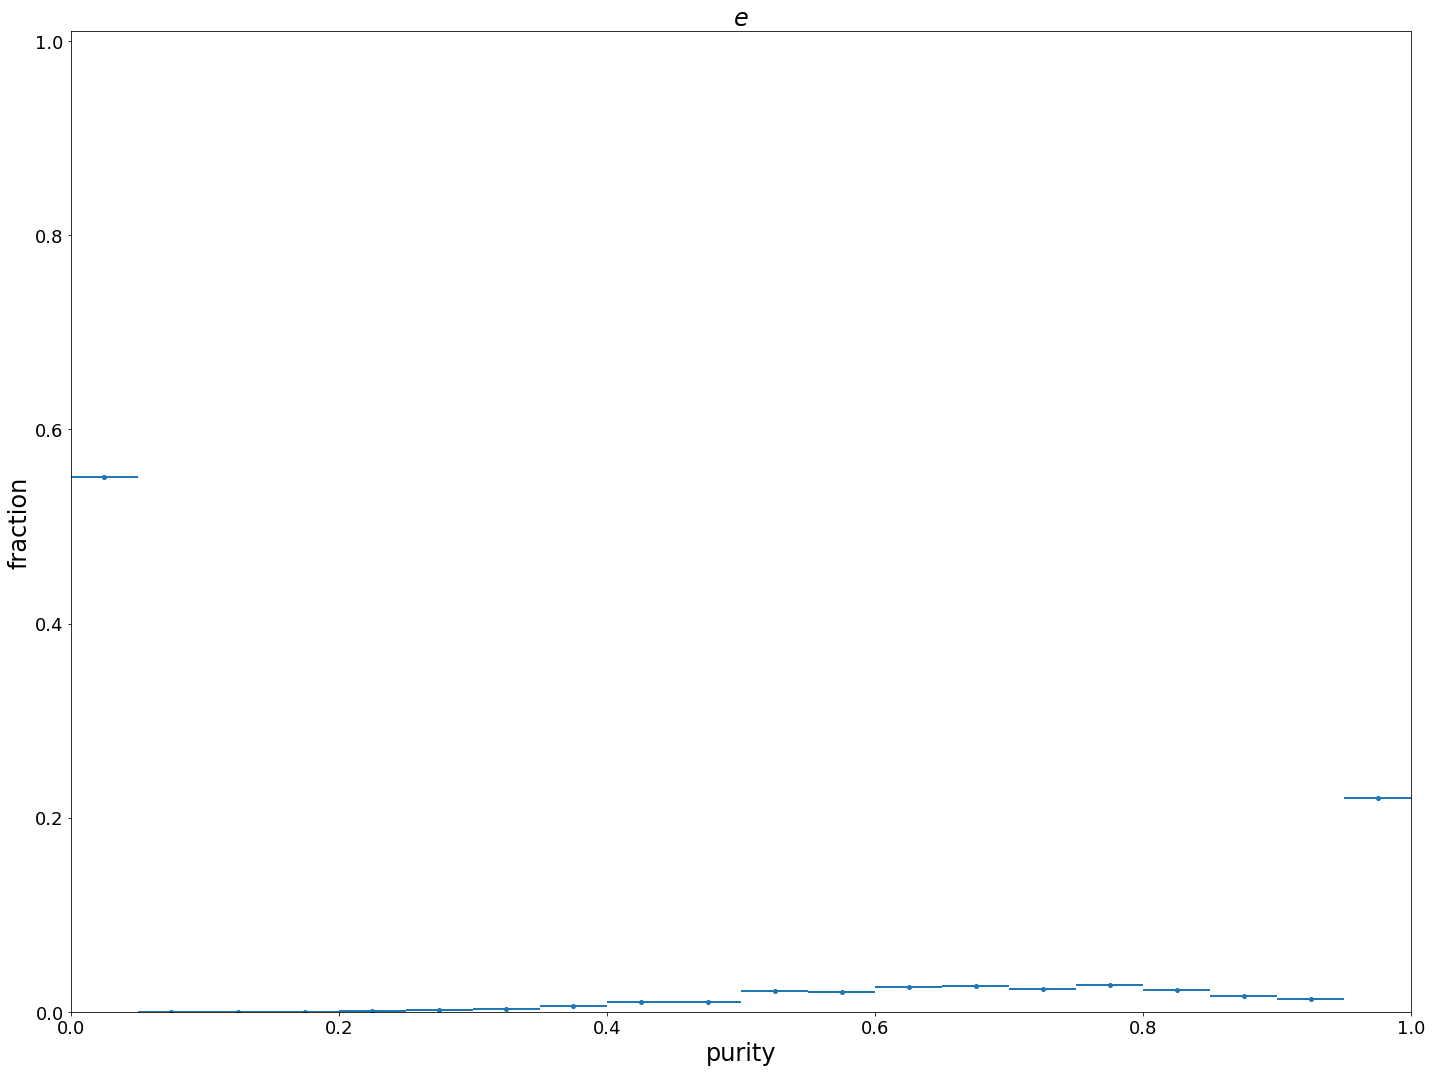

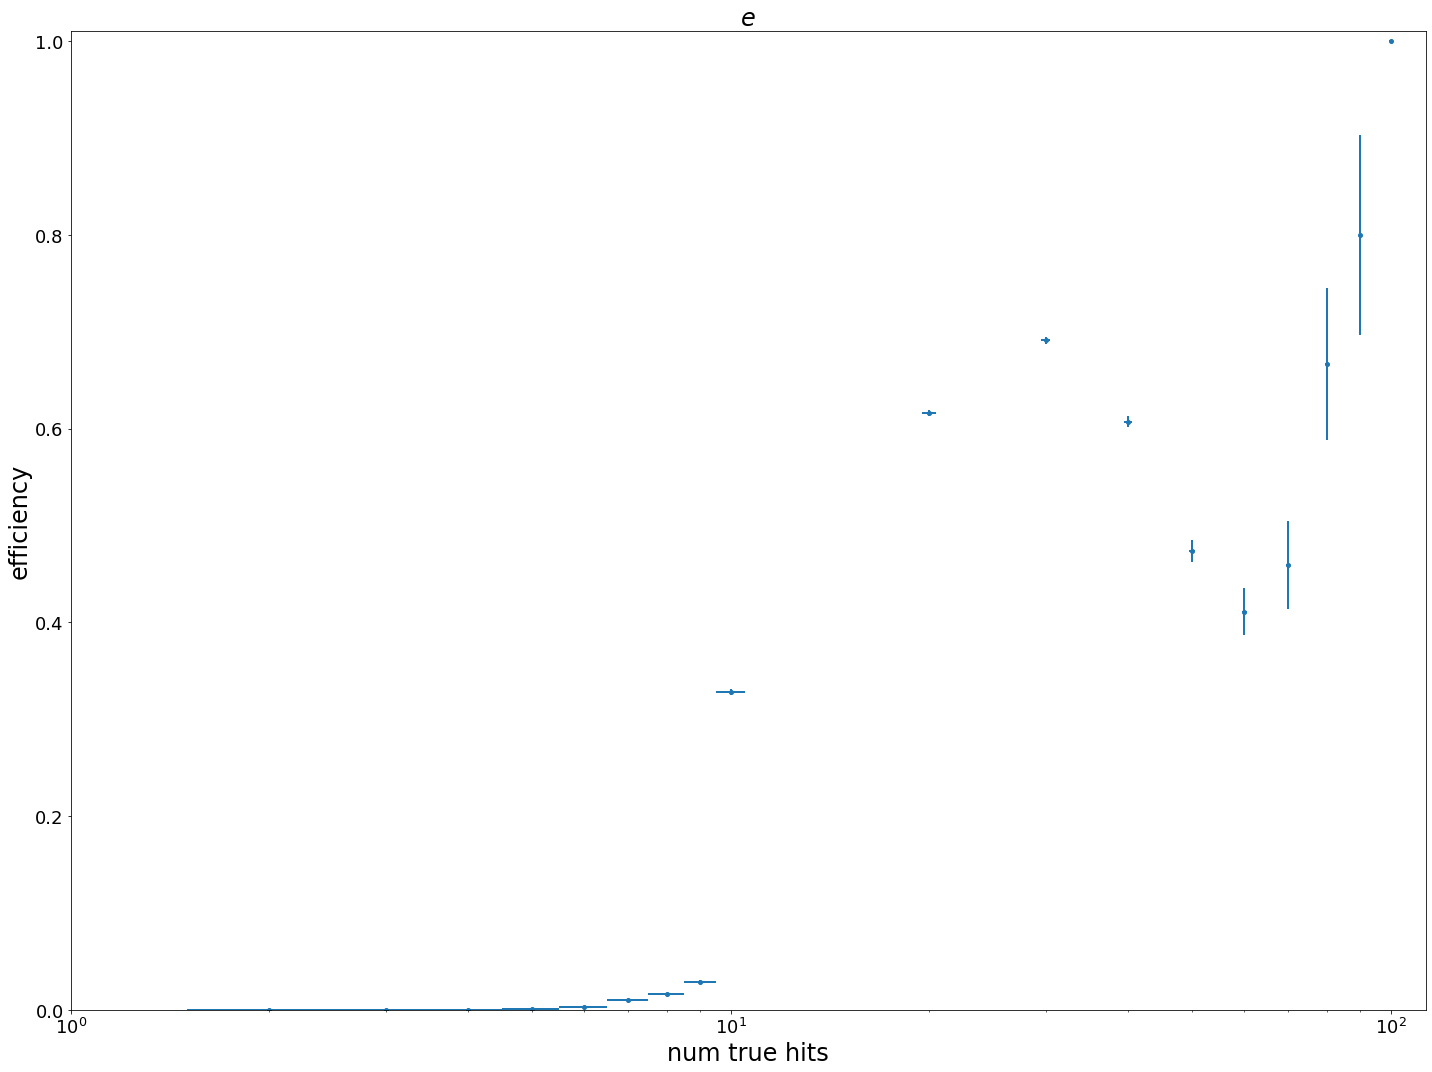

ValueError: zero-size array to reduction operation minimum which has no identity

In [14]:
for pdg in pdg_to_id:
    idx = np.where(abs(validation.mc_pdg) == pdg)
    mc_nhits = validation.mc_nhits[idx]
    mc_mom = validation.mc_momentum[idx]
    completeness_array, purity_array, efficiency_array = get_metric_arrays(validation, idx)
    make_completeness_plots(pdg, completeness_array, mc_nhits, mc_mom, f"inc_completeness_{pdg}")
    make_purity_plots(pdg, purity_array, mc_nhits, mc_mom, f"inc_purity_{pdg}")
    make_efficiency_plots(pdg, efficiency_array, mc_nhits, mc_mom, f"inc_efficiency_{pdg}")

## Particle metrics by interaction type (CC)

In [ ]:
for int_type in ["qe", "res", "dis", "coh"]:
    if int_type == "qe": type_target = validation.is_qe == True
    elif int_type == "res": type_target = validation.is_res == True
    elif int_type == "dis": type_target = validation.is_dis == True
    elif int_type == "coh": type_target = validation.is_coh == True
    type_match = type_target & (validation.is_cc == True)
    for pdg in pdg_to_id:
        pdg_match = abs(validation.mc_pdg) == pdg
        idx = np.where(pdg_match & type_match)
        if len(idx[0]) > 0:
            mc_nhits = validation.mc_nhits[idx]
            mc_mom = validation.mc_momentum[idx]
            completeness_array, purity_array, efficiency_array = get_metric_arrays(validation, idx)
            make_completeness_plots(pdg, completeness_array, mc_nhits, mc_mom, f"cc{int_type}_completeness_{pdg}")
            make_purity_plots(pdg, purity_array, mc_nhits, mc_mom, f"cc{int_type}_purity_{pdg}")
            make_efficiency_plots(pdg, efficiency_array, mc_nhits, mc_mom, f"cc{int_type}_efficiency_{pdg}")

## Particle metrics by interaction type (NC)

In [ ]:
for int_type in ["qe", "res", "dis", "coh"]:
    if int_type == "qe": type_target = validation.is_qe == True
    elif int_type == "res": type_target = validation.is_res == True
    elif int_type == "dis": type_target = validation.is_dis == True
    elif int_type == "coh": type_target = validation.is_coh == True
    type_match = type_target & (validation.is_cc == False)
    for pdg in pdg_to_id:
        pdg_match = abs(validation.mc_pdg) == pdg
        idx = np.where(pdg_match & type_match)
        if len(idx[0]) > 0:
            mc_nhits = validation.mc_nhits[idx]
            mc_mom = validation.mc_momentum[idx]
            completeness_array, purity_array, efficiency_array = get_metric_arrays(validation, idx)
            make_completeness_plots(pdg, completeness_array, mc_nhits, mc_mom, f"nc{int_type}_completeness_{pdg}")
            make_purity_plots(pdg, purity_array, mc_nhits, mc_mom, f"nc{int_type}_purity_{pdg}")
            make_efficiency_plots(pdg, efficiency_array, mc_nhits, mc_mom, f"nc{int_type}_efficiency_{pdg}")

# Event validation

In [ ]:
class EventValidation:
    def __init__(self, filename, treename):
        file = uproot.open(filename)
        tree = file[treename]
        self.event = tree['event'].array(library="np") #linear list of events
        self.orig_event = tree["event"].array(library="np") #actual event number
        self.file = np.zeros_like(self.event)
        self.is_cc = tree["isCC"].array(library="np")
        self.is_qe = tree["isQE"].array(library="np")
        self.is_res = tree["isResonant"].array(library="np")
        self.is_dis = tree["isDIS"].array(library="np")
        self.is_coh = tree["isCoherent"].array(library="np")
        self.is_numu = tree["isNuMu"].array(library="np")
        self.is_nue = tree["isNuE"].array(library="np")
        self.n_pizero = tree["nPiZero"].array(library="np")
        self.n_pic = tree["nPiMinus"].array(library="np") + tree["nPiPlus"].array(library="np")
        self.n_photons = tree["nPhotons"].array(library="np")
        self.n_protons = tree["nProtons"].array(library="np")
        self.is_fiducial = tree["isFiducial"].array(library="np")
        self.nu_vtx_dx = tree["vtxDx"].array(library="np")
        self.nu_vtx_dy = tree["vtxDy"].array(library="np")
        self.nu_vtx_dz = tree["vtxDr"].array(library="np")
        self.nu_vtx_dr = tree["vtxDz"].array(library="np")
        self.n_good_matches = tree["nGoodMatches"].array(library="np")
        self.n_poor_matches = tree["nPoorMatches"].array(library="np")
        self.n_unmatched = tree["nUnmatched"].array(library="np")
        self.n_nodes = tree["nNodes"].array(library="np")
        self.n_good_tier1_matches = tree["nGoodTier1Matches"].array(library="np")
        self.n_tier1_nodes = tree["nTier1Nodes"].array(library="np")
        self.n_good_track_matches = tree["nGoodTrackMatches"].array(library="np")
        self.n_track_nodes = tree["nTrackNodes"].array(library="np")
        self.n_good_shower_matches = tree["nGoodShowerMatches"].array(library="np")
        self.n_shower_nodes = tree["nShowerNodes"].array(library="np")
        self.n_good_tier1_track_matches = tree["nGoodTier1TrackMatches"].array(library="np")
        self.n_track_tier1_nodes = tree["nTier1TrackNodes"].array(library="np")
        self.n_good_tier1_shower_matches = tree["nGoodTier1ShowerMatches"].array(library="np")
        self.n_tier1_shower_nodes = tree["nTier1ShowerNodes"].array(library="np")
        
        self.has_leading_muon = tree["hasLeadingMuon"].array(library="np")
        self.has_leading_electron = tree["hasLeadingElectron"].array(library="np")
        self.is_leading_lepton_correct = tree["isLeadingLeptonCorrect"].array(library="np")
        file.close()
        make_sequential(self)

In [ ]:
validation = EventValidation("validation_event.root", "event")

In [ ]:
def plot_histogram_2d(x, y, plot_format):
    plt.rcParams["figure.figsize"] = (20, 15)
    fig, ax = plt.subplots()
    
    ax.set_title(plot_format.title, fontsize=plot_format.titlesize)
    ax.tick_params(axis='x', labelsize=plot_format.labelsize)
    ax.tick_params(axis='y', labelsize=plot_format.labelsize)
    ax.set_xlabel(plot_format.xlabel, fontsize=plot_format.titlesize)
    ax.set_ylabel(plot_format.ylabel, fontsize=plot_format.titlesize)
    if not plot_format.xlim is None:
        plt.xlim(plot_format.xlim[0], plot_format.xlim[1])
    if not plot_format.ylim is None:
        plt.ylim(plot_format.ylim[0], plot_format.ylim[1])
        
    bins = np.linspace(0, np.max(x), np.max(x) + 1)
    hist, *_ = np.histogram2d(x, y, bins=(bins, bins))
    for i in range(len(hist)):
        row_sum = hist[i].sum()
        hist[i] *= 1 / row_sum if row_sum > 0 else 1
    hist = hist.T

    cmap = plt.cm.get_cmap('coolwarm')
    plt.pcolormesh(bins, bins, hist, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar()
    
    plt.tight_layout()
    save_plot(fig, plot_format.filename)
    
    plt.show()

## Inclusive event metrics

In [ ]:
plot_format = PlotFormat(title="Feature - Base : Inclusive", xlabel="true nodes", ylabel="reconstructed nodes",
                         filename=f"inc_particle_frac")
plot_histogram_2d(validation.n_nodes, validation.n_good_matches, plot_format)

In [ ]:
efficiency_array = np.array(validation.n_nodes == validation.n_good_matches)
bins = np.linspace(0, np.max(validation.n_protons), 1 + np.max(validation.n_protons))
plot_format = PlotFormat(title="Correct Event Fraction - Inclusive", xlabel="n protons", ylabel="correct event fraction",
                         xlim=(0, np.max(validation.n_protons)), ylim=(0, 1.01),
                         filename=f"inc_correct_event_fraction")
metric = get_efficiency(efficiency_array, validation.n_protons, bins)
plot_metric(metric.x, metric.y, metric.y_errs, plot_format, "efficiency")

## Event metrics by interaction type (CC)

In [ ]:
for int_type in ["qe", "res", "dis"]:
    if int_type == "qe": type_target = validation.is_qe == True
    elif int_type == "res": type_target = validation.is_res == True
    elif int_type == "dis": type_target = validation.is_dis == True
    elif int_type == "coh": type_target = validation.is_coh == True
    type_match = type_target & (validation.is_cc == True)
    idx = np.where(type_match)
    if len(idx[0]) > 0:
        plot_format = PlotFormat(title=f"Feature - Base : CC{int_type.upper()}", xlabel="true nodes",
                                 ylabel="reconstructed nodes", filename=f"cc{int_type}_particle_frac")
        plot_histogram_2d(validation.n_nodes[idx], validation.n_good_matches[idx], plot_format)

        efficiency_array = np.array(validation.n_nodes[idx] == validation.n_good_matches[idx])
        bins = np.linspace(0, np.max(validation.n_protons[idx]), 1 + np.max(validation.n_protons[idx]))
        plot_format = PlotFormat(title=f"Correct Event Fraction - CC{int_type.upper()}", xlabel="n protons", ylabel="correct event fraction",
                                 xlim=(0, np.max(validation.n_protons[idx])), ylim=(0, 1.01),
                                 filename=f"cc{int_type}_correct_event_fraction")
        metric = get_efficiency(efficiency_array, validation.n_protons[idx], bins)
        plot_metric(metric.x, metric.y, metric.y_errs, plot_format, "efficiency")

## Event metrics by interaction type (NC)

In [ ]:
for int_type in ["qe", "res", "dis"]:
    if int_type == "qe": type_target = validation.is_qe == True
    elif int_type == "res": type_target = validation.is_res == True
    elif int_type == "dis": type_target = validation.is_dis == True
    elif int_type == "coh": type_target = validation.is_coh == True
    type_match = type_target & (validation.is_cc == False)
    idx = np.where(type_match)
    if len(idx[0]) > 0:
        plot_format = PlotFormat(title=f"Feature - Base : NC{int_type.upper()}", xlabel="true nodes", ylabel="reconstructed nodes",
                                 filename=f"nc{int_type}_particle_frac")
        plot_histogram_2d(validation.n_nodes[idx], validation.n_good_matches[idx], plot_format)
        
        efficiency_array = np.array(validation.n_nodes[idx] == validation.n_good_matches[idx])
        bins = np.linspace(0, np.max(validation.n_protons[idx]), 1 + np.max(validation.n_protons[idx]))
        plot_format = PlotFormat(title=f"Correct Event Fraction - NC{int_type.upper()}", xlabel="n protons", ylabel="correct event fraction",
                                 xlim=(0, np.max(validation.n_protons[idx])), ylim=(0, 1.01),
                                 filename=f"nc{int_type}_correct_event_fraction")
        metric = get_efficiency(efficiency_array, validation.n_protons[idx], bins)
        plot_metric(metric.x, metric.y, metric.y_errs, plot_format, "efficiency")